In [1]:
import gym
import numpy as np
import seaborn
import matplotlib.pyplot as plt

env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
env = env.unwrapped

gamma = 0.9


def action_inverse(list_oh_actions):
    ans = 0
    if int(list_oh_actions[1]) == 1:
        ans = 1
    if int(list_oh_actions[2]) == 1:
        ans = 2
    if int(list_oh_actions[3]) == 1:
        ans = 3

    return ans


def fancy_visual(value_func, policy_int):
    grid = 4
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
    reshaped = np.reshape(value_func, (grid, grid))
    seaborn.heatmap(reshaped, cmap="icefire", vmax=1.1, robust=True,
                    square=True, xticklabels=grid + 1, yticklabels=grid + 1,
                    linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt="f")
    counter = 0
    for j in range(0, 4):
        for i in range(0, 4):
            if int(policy_int[counter]) == 1:
                plt.text(i + 0.5, j + 0.7, u'\u2193', fontsize=12)
            elif int(policy_int[counter]) == 3:
                plt.text(i + 0.5, j + 0.7, u'\u2191', fontsize=12)
            elif int(policy_int[counter]) == 0:
                plt.text(i + 0.5, j + 0.7, u'\u2190', fontsize=12)
            else:
                plt.text(i + 0.5, j + 0.7, u'\u2192', fontsize=12)
            counter = counter + 1

    plt.title('Heatmap of policy iteration with value function values and directions')
    print('Value Function', value_func)
    print('Policy', policy_int)
    plt.savefig("heatmap_pi.png", dpi=300)
    plt.show()


def calc_pi_v_s(state, value_function, P, policy, gamma=0.9):
    dict_state = P[state]
    value_s_a = 0
    for action, dict_action in dict_state.items():
        cumulative_reward = 0
        for prob_ns_r, next_state, reward, is_terminal in dict_action:
            cumulative_reward += prob_ns_r * (reward + gamma * value_function[next_state])
        value_s_a += policy[state][action] * cumulative_reward
    return value_s_a


def policy_evaluation(P, nS, nA, policy, gamma=0.9, delta=1e-3):
    value_function = np.zeros(nS)
    temp_v = value_function.copy()
    while True:
        temp_v = value_function.copy()
        for state, dict_state in P.items():
            value_function[state] = calc_pi_v_s(state, value_function, P, policy, gamma)
        diff = np.max(np.abs(temp_v - value_function))
        if diff <= delta:
            break
    return value_function


def choose_action(state, value_function, P, gamma):
    dict_state = P[state]
    best_action = 0
    max_val_s_a = 0
    for action, dict_action in dict_state.items():
        cumulative_reward = 0
        for prob_ns_r, next_state, reward, is_terminal in dict_action:
            cumulative_reward += prob_ns_r * (reward + gamma * value_function[next_state])
        if max_val_s_a < cumulative_reward:
            max_val_s_a = cumulative_reward
            best_action = action
    return best_action


def policy_improvement(P, nS, nA, value_from_policy, gamma=0.9):
    new_policy = np.zeros([nS, nA])

    for state, dict_state in P.items():
        new_action = choose_action(state, value_from_policy, P, gamma)
        new_policy[state][new_action] = 1.0
    return new_policy


def policy_iteration(P, nS, nA, policy, gamma=0.9, delta=1e-3):
    new_policy = policy.copy()
    value_function = policy_evaluation(P, nS, nA, new_policy, gamma, delta)
    v_k_diff = []
    count = 0
    while True:
        count += 1
        old_value_function = value_function.copy()
        new_policy = policy_improvement(P, nS, nA, value_function, gamma)
        is_policy_stable = True
        for state, dict_state in P.items():
            old_action = np.argmax(policy[state])
            new_action = np.argmax(new_policy[state])

            if old_action != new_action:
                is_policy_stable = False
        policy = new_policy.copy()
        value_function = policy_evaluation(P, nS, nA, new_policy, gamma=0.9, delta=1e-3)
        diff = old_value_function - value_function

        v_k_diff.append(np.linalg.norm(diff, ord=2))
        if is_policy_stable:
            break

    print(count)
    num_iterations = [i for i in range(len(v_k_diff))]
    plt.plot(num_iterations, v_k_diff)
    plt.xlabel("Number of iterations")
    plt.ylabel("Value Difference")
    plt.title("Value Contraction")
    plt.savefig("Policy_iteration_Contraction.png", dpi=300)
    plt.show()

    return new_policy, value_function


def perform_policy_iteration():
    random_policy1 = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n

    policy_pi, v_pi = policy_iteration(env.P, env.observation_space.n, env.action_space.n, random_policy1)
    policy_int = [action_inverse(list_oh_actions) for list_oh_actions in policy_pi]
    fancy_visual(v_pi, policy_int)



3


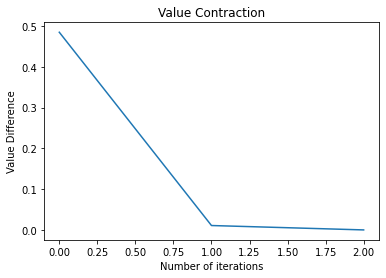

Value Function [0.06476289 0.05841569 0.07252933 0.05378964 0.08867795 0.
 0.11137269 0.         0.14325408 0.24628655 0.29886952 0.
 0.         0.37915415 0.63865133 0.        ]
Policy [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]


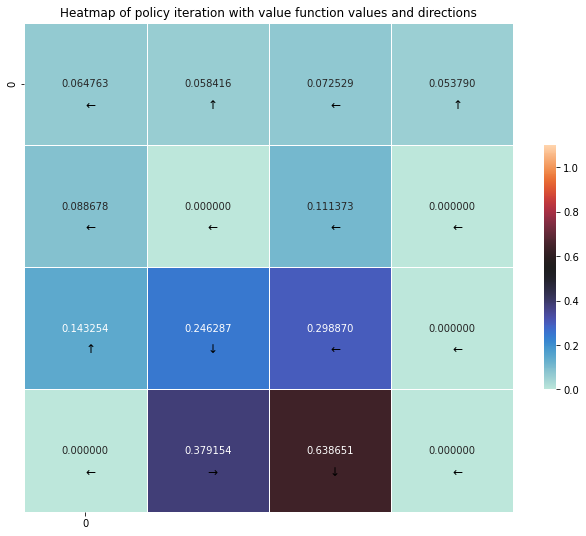

In [2]:
perform_policy_iteration()